In [1]:
import pandas as pd
from text_authorship.ta_model.stacking import TAStack2

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\annag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('../Documents/MLDS_writers_transformed_full/prepared_df.csv')

In [3]:
book_counts = df.groupby('book').size()
df['counts'] = df.book.map(book_counts)

In [4]:
from text_authorship.ta_model.model_selection import train_test_split

In [5]:
df_train, df_test, y_train, y_test = train_test_split(df, share=0.75)

In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [12]:
from text_authorship.ta_model.stacking import TAVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

vectorizer = TAVectorizer(cols=['text_no_punkt', 'lemmas', 'tags', 'tokens'])
base_estimator = LogisticRegression(class_weight='balanced', max_iter=500, C=1000)
stacking = TAStack2(vectorizer=vectorizer, base_estimator=base_estimator, final_estimator=XGBClassifier())

In [13]:
stacking.fit(df_train, y_train)

C:\Users\annag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\annag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

TAStack2(base_estimator=LogisticRegression(C=1000, class_weight='balanced',
                                           max_iter=500),
         cv=[(Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            25561, 25562, 25563, 25564, 25565, 25566, 25567, 25568, 25569,
            25570],
           dtype='int64', length=19746),
              Int64Index([ 2032,  2033,  2034,  2035,  2036,  2037,  2038,  2039,  2040,
             2041,
            ...
            25398, 25399, 25400, 25401, 25491, 25492, 25493, 25494, 25495,
            25496],
           dtype='...
                                       learning_rate=None, max_bin=None,
                                       max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=None,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=100, n_jobs=None,
                                       num_parallel_tree=None, predictor=None,
                                       random_state=None, ...),
         vectorizer=TAVectorizer(cols=['text_no_punkt', 'lemmas', 'tags',
                                       'tokens']))

In [14]:
predictions = stacking.predict(df_test)

In [7]:
from sklearn.metrics import confusion_matrix

In [16]:
stacking_cm = confusion_matrix(y_test, predictions)
stacking_cm = pd.DataFrame(stacking_cm, columns=encoder.classes_, index=encoder.classes_)

In [17]:
stacking_cm

,Аверченко,Булгаков,Бунин,Гоголь,Горький,Достоевский,Карамзин,Куприн,Лермонтов,Мордовцев,Пушкин,Салтыков-Щедрин,Толстой,Тургенев,Чехов
Аверченко,473,10,1,0,2,4,0,5,0,0,0,4,0,0,4
Булгаков,46,915,36,1,14,2,0,43,0,6,1,4,4,0,6
Бунин,2,2,523,0,0,1,0,11,0,0,0,3,2,0,0
Гоголь,1,0,1,148,0,4,0,0,0,0,1,3,5,0,0
Горький,2,2,5,0,294,2,0,9,1,1,0,1,7,0,1
Достоевский,10,14,28,28,5,1665,0,7,4,6,5,65,17,10,5
Карамзин,0,0,0,0,0,0,19,0,0,3,7,1,0,0,0
Куприн,9,7,6,7,4,12,0,420,1,9,0,4,3,3,5
Лермонтов,0,0,5,19,6,6,7,9,21,6,22,1,12,8,1
Мордовцев,1,0,6,1,2,4,1,2,0,345,2,2,4,0,0


In [8]:
from sklearn.metrics import f1_score

In [19]:
stacking_f1 = f1_score(y_test, predictions, average='macro')
stacking_f1

0.7905698104203851

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader

In [17]:
tokenizer = BertTokenizer.from_pretrained('../HSE_mlds/project/bert_train_val', do_lower_case=False)
bert = BertForSequenceClassification.from_pretrained('../HSE_mlds/project/bert_train_val')

In [18]:
import torch

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
bert = bert.to(device)

In [19]:
def collate_fn(batch: list[str]):
    tokenized = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors='pt')
    tokenized = {k: v.to(device) for k, v in tokenized.items()}
    return tokenized

loader = DataLoader(df_test['text_w_no_ref'].tolist(), batch_size=32, shuffle=False, collate_fn=collate_fn)

In [20]:
from tqdm.notebook import tqdm

bert.eval()

predictions_b = []

with torch.inference_mode():
    for batch in tqdm(loader):
        output = bert(**batch)
        logits = output.get('logits')
        labels = torch.argmax(logits, dim=1).detach().cpu().tolist()
        predictions_b.extend(labels)

  0%|          | 0/247 [00:00<?, ?it/s]

In [21]:
bert_cm = confusion_matrix(y_test, predictions_b)
bert_cm = pd.DataFrame(bert_cm, index = encoder.classes_, columns=encoder.classes_)

In [22]:
bert_cm

,Аверченко,Булгаков,Бунин,Гоголь,Горький,Достоевский,Карамзин,Куприн,Лермонтов,Мордовцев,Пушкин,Салтыков-Щедрин,Толстой,Тургенев,Чехов
Аверченко,482,6,1,0,0,0,0,12,0,0,0,0,0,0,2
Булгаков,45,910,26,0,11,0,0,81,0,0,0,0,1,0,4
Бунин,7,0,519,0,0,0,0,18,0,0,0,0,0,0,0
Гоголь,0,0,0,125,0,6,0,0,6,3,1,2,15,0,5
Горький,0,0,0,0,249,0,0,6,0,36,0,0,2,7,25
Достоевский,0,12,55,11,4,1649,0,18,0,5,4,46,49,9,7
Карамзин,0,0,0,0,0,0,27,0,0,1,2,0,0,0,0
Куприн,4,0,4,1,0,0,0,479,0,0,0,0,1,0,1
Лермонтов,0,0,0,18,1,2,14,5,21,1,3,0,0,54,4
Мордовцев,0,0,3,0,0,0,0,3,0,359,0,2,0,0,3


In [23]:
bert_f1 = f1_score(y_test, predictions_b, average='macro')
bert_f1

0.7719907059484409

In [7]:
import numpy as np
with open("../HSE_mlds/project/bert_cm.txt") as f:
    data = f.read().strip().split()
lines =[]
start = 0
for i in range(15):
    lines.append(list(map(int, data[start: start+15])))
    start+=16
cm = np.array(lines)

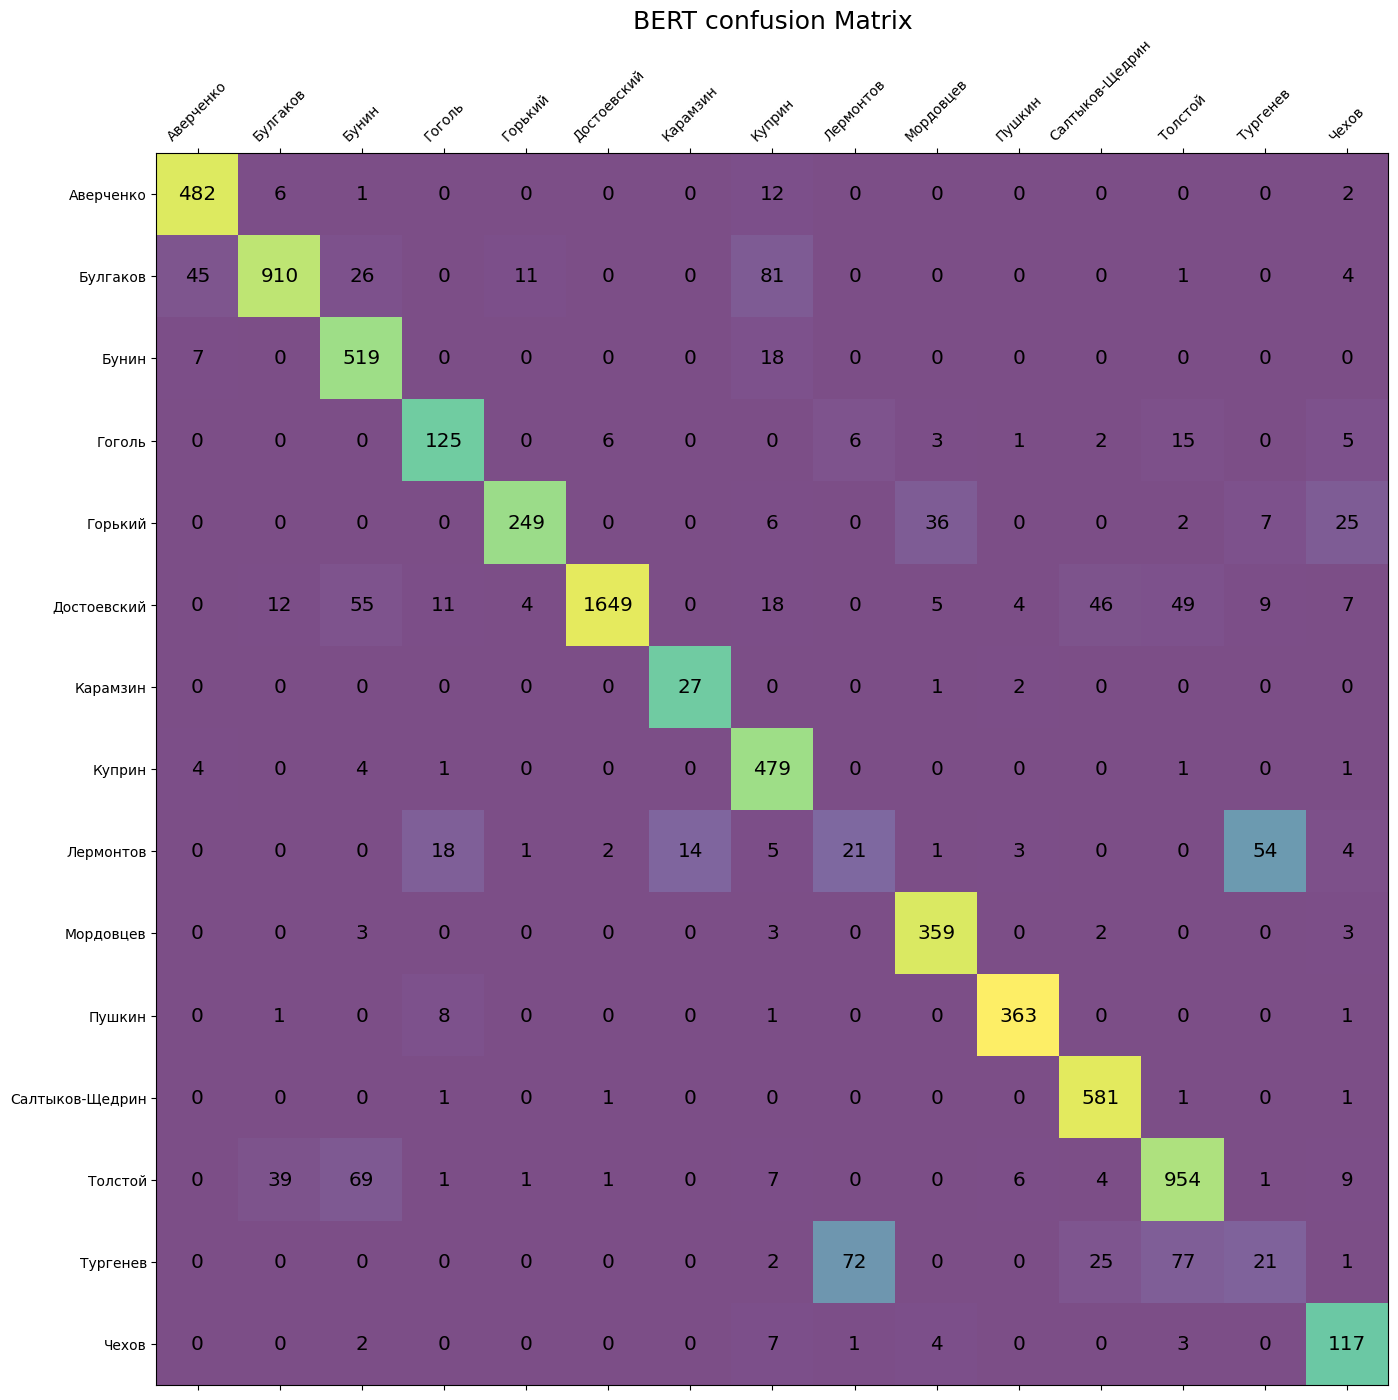

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16))
color_map = np.full_like(cm, 0, dtype=np.float64)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='x-large')
        color_map[i,j] = cm[i,j] / (np.sum(cm[i]) + np.sum(cm[:,j]) - cm[i,j])
ax.matshow(color_map, cmap=mpl.colormaps['viridis'], alpha=0.7)
authors = encoder.classes_
ax.set_xticks(range(len(authors)))
ax.set_xticklabels(authors, rotation=45)
ax.set_yticks(range(len(authors)))
ax.set_yticklabels(authors)
plt.title('BERT confusion Matrix', fontsize=18)
plt.show()